# Import libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

from ta.momentum import rsi, stoch, stoch_signal
from ta.volatility import average_true_range
from ta.volume import on_balance_volume

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import MaxPooling1D, Flatten, Conv1D
from keras.wrappers.scikit_learn import KerasRegressor

# Get data from Yahoo Finance


In [2]:
def get_stock_data(ticker, start_date, end_date):

    df = yf.download(ticker, start=start_date, end=end_date)

    # Basic Price and Volume Data
    df['Open'] = df['Open']
    df['High'] = df['High']
    df['Low'] = df['Low']
    df['Close'] = df['Close']
    df['Adj Close'] = df['Adj Close']
    df['Volume'] = df['Volume']

    # Daily and Moving Average Indicators
    df['DailyReturn'] = df['Close'].pct_change()
    df['MA_10'] = df['Close'].rolling(window=10).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    df['EMA_100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Volatility and Trend Indicators
    df['Volatility_bbh'] = df['Close'].rolling(window=20).mean() + 2 * df['Close'].rolling(window=20).std()
    df['Volatility_bbl'] = df['Close'].rolling(window=20).mean() - 2 * df['Close'].rolling(window=20).std()
    df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()

    # Technical Indicators
    df['RSI'] = rsi(df['Close'], window=14)
    df['ATR'] = average_true_range(df['High'], df['Low'], df['Close'], window=14)
    df['OBV'] = on_balance_volume(df['Close'], df['Volume'])

    df.reset_index(inplace=True)

    # Valuation ratios
    if ticker in ['AAPL', 'AMZN', 'GOOGL', 'MSFT']:
        stock = yf.Ticker(ticker)
        df['PE_TTM'] = stock.info.get('trailingPE')
        df['EPS_TTM'] = stock.info.get('trailingEps')
        df['PB'] = stock.info.get('priceToBook')
        df['PS_TTM'] = stock.info.get('priceToSalesTrailing12Months')
        df['Dividend_Yield'] = stock.info.get('dividendYield')

    return df

# Global Variables

In [3]:
start_date = '2019-01-01'
end_date = '2024-08-30'

# Data:
### Nasdaq Composite Index (IXIC), Standard & Poor's 500 Index (SP500), Dow Jones Industrial Average (DJI)

In [4]:
df_nasdaq = get_stock_data('^IXIC', start_date, end_date)
df_sp500 = get_stock_data('^GSPC', start_date, end_date)
df_dji = get_stock_data('^DJI', start_date, end_date)

stocks = {'df_nasdaq': df_nasdaq, 'df_sp500': df_sp500, 'df_dji': df_dji}

for name, df in stocks.items():
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    filename = f"{name}.csv"
    df.to_csv(filename, index=False)
    print(f'Shape of {name}: {df.shape}')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of df_nasdaq: (1372, 19)
Shape of df_sp500: (1372, 19)
Shape of df_dji: (1372, 19)


In [5]:
df_nasdaq.head()

,Date,Open,High,Low,Close,Adj Close,Volume,DailyReturn,MA_10,MA_20,MA_50,EMA_100,EMA_200,Volatility_bbh,Volatility_bbl,MACD,RSI,ATR,OBV
0,2019-03-14,7644.790039,7653.100098,7627.020020,7630.910156,7630.910156,2198900000,-0.001635,7550.820996,7528.072974,7265.048994,7090.512523,6916.355483,7663.704392,7392.441556,87.768229,65.539632,81.998956,32262520000
1,2019-03-15,7658.410156,7714.959961,7652.040039,7688.529785,7688.529785,3451860000,0.007551,7560.138965,7541.151953,7285.500791,7102.354449,6924.038809,7685.869330,7396.434577,92.460645,68.696734,82.145445,35714380000
2,2019-03-18,7696.379883,7737.669922,7677.740234,7714.479980,7714.479980,2302140000,0.003375,7573.829980,7553.255444,7310.520391,7114.475747,6931.903895,7713.431069,7393.079820,97.153458,70.028512,80.558605,38016520000
3,2019-03-19,7747.399902,7767.890137,7699.149902,7723.950195,7723.950195,2457920000,0.001228,7588.589014,7565.114453,7330.222197,7126.544548,6939.784953,7739.090108,7391.138798,100.478460,70.521406,79.714436,40474440000
4,2019-03-20,7721.950195,7779.240234,7674.040039,7728.970215,7728.970215,2464230000,0.000650,7610.894043,7577.109473,7348.332197,7138.473769,6947.637543,7761.762248,7392.456697,102.338923,70.795578,81.534847,42938670000


In [6]:
df_nasdaq.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'DailyReturn', 'MA_10', 'MA_20', 'MA_50', 'EMA_100', 'EMA_200',
       'Volatility_bbh', 'Volatility_bbl', 'MACD', 'RSI', 'ATR', 'OBV'],
      dtype='object')

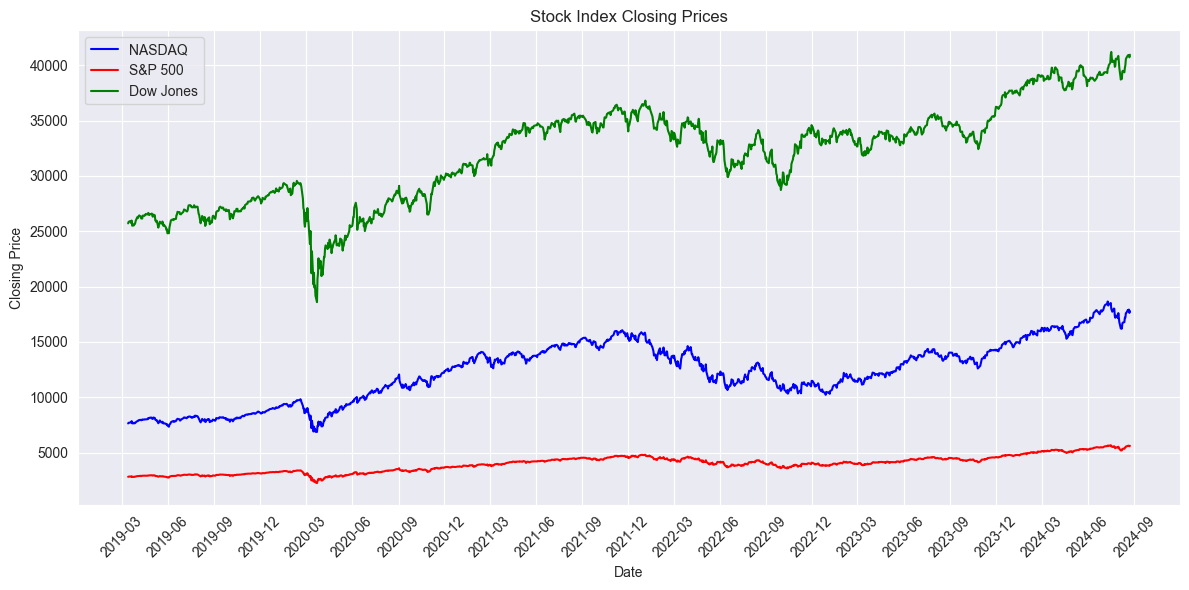

In [7]:
plt.figure(figsize=(12, 6))

plt.plot(pd.to_datetime(df_nasdaq['Date']), df_nasdaq['Close'], label='NASDAQ', color='blue')
plt.plot(pd.to_datetime(df_sp500['Date']), df_sp500['Close'], label='S&P 500', color='red')
plt.plot(pd.to_datetime(df_dji['Date']), df_dji['Close'], label='Dow Jones', color='green')

plt.title('Stock Index Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Data Preprocessing

In [13]:
feature = ['Open', 'High', 'Low', 'Volume', 'DailyReturn', 'Adj Close',
           'MA_10', 'MA_20', 'MA_50', 'EMA_100', 'EMA_200', 
           'Volatility_bbh', 'Volatility_bbl', 'MACD', 'RSI', 'ATR','OBV']
# Result of XGBoost feature selection, according to 7600_code_XGB_part
feature_xgb = ['Adj Close', 'High', 'Low', 'Open', 'MA_10', 'Volatility_bbl']
target = 'Close'

df_nasdaq_preprocessed = df_nasdaq[[target] + feature_xgb]
df_sp500_preprocessed = df_sp500[[target] + feature_xgb]
df_dji_preprocessed = df_dji[[target] + feature_xgb]

In [14]:
def split_data(stock):
    stock = stock.to_numpy()
    test_set_size = int(np.round(0.2 * len(stock)))
    val_set_size = int(np.round(0.2 * len(stock)))
    train_set_size = len(stock) - test_set_size - val_set_size
    
    train = stock[:train_set_size, :]
    val = stock[train_set_size: train_set_size+val_set_size, :]
    test = stock[train_set_size+val_set_size:, :]

    return (train, val, test)

train, val, test = split_data(df_nasdaq_preprocessed)

In [15]:
# Standardize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

print(f'Shape of scaled training Set: {scaled_train.shape}')
print(f'Shape of scaled training Set: {scaled_val.shape}')
print(f'Shape of scaled testing Set: {scaled_test.shape}')

Shape of scaled training Set: (824, 7)
Shape of scaled training Set: (274, 7)
Shape of scaled testing Set: (274, 7)


In [16]:
def createXY(dataset,lookback):
    dataX = []
    dataY = []
    for i in range(lookback, len(dataset)):
            dataX.append(dataset[i - lookback:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

lookback = 30

X_train, y_train = createXY(scaled_train,lookback)
X_val, y_val = createXY(scaled_val,lookback)
X_test, y_test = createXY(scaled_test,lookback)

print(f"shape of X_train:{np.shape(X_train)}, shape of y_train:{np.shape(y_train)}")
print(f"shape of X_train:{np.shape(X_val)}, shape of y_train:{np.shape(y_val)}")
print(f"shape of X_test:{np.shape(X_test)}, shape of y_test:{np.shape(y_test)}")

shape of X_train:(794, 30, 7), shape of y_train:(794,)
shape of X_train:(244, 30, 7), shape of y_train:(244,)
shape of X_test:(244, 30, 7), shape of y_test:(244,)


## Model 1 - LSTM

In [17]:
# GridSearchCV for Hyperparameters

def create_model(optimizer='adam'):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model = KerasRegressor(build_fn=create_model, verbose=1, validation_data=(X_test,y_test), epochs=5, batch_size=4)

parameters = {'optimizer': ['Adam', 'Adadelta', 'SGD', 'RMSprop', 'Adagrad']}


grid = GridSearchCV(estimator = model, param_grid = parameters)
grid_result = grid.fit(X_train, y_train)
print(f"The best hyperparameters are: {grid_result.best_params_}")


C:\Users\83995\AppData\Local\Temp\ipykernel_23636\51252046.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=1, validation_data=(X_test,y_test), epochs=5, batch_size=4)


Epoch 1/5
159/159 [==============================] - 5s 16ms/step - loss: 0.0168 - val_loss: 0.0155
Epoch 2/5
159/159 [==============================] - 2s 12ms/step - loss: 0.0083 - val_loss: 0.0069
Epoch 3/5
159/159 [==============================] - 2s 14ms/step - loss: 0.0061 - val_loss: 0.0028
Epoch 4/5
159/159 [==============================] - 2s 12ms/step - loss: 0.0058 - val_loss: 0.0040
Epoch 5/5
40/40 [==============================] - 1s 2ms/step - loss: 2.4069e-04
Epoch 1/5
159/159 [==============================] - 5s 18ms/step - loss: 0.0199 - val_loss: 0.0111
Epoch 2/5
159/159 [==============================] - 2s 13ms/step - loss: 0.0066 - val_loss: 0.0022
Epoch 3/5
159/159 [==============================] - 2s 13ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 4/5
159/159 [==============================] - 2s 13ms/step - loss: 0.0060 - val_loss: 0.0035
Epoch 5/5
40/40 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 1/5
159/159 [=====================

In [18]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='SGD', metrics=['mse', 'mae'])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=4)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 30, 50)            11600     
                                                                 
 dropout_68 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_69 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_69 (Dropout)        (None, 50)                0         
                                                                 
 dense_34 (Dense)            (None, 1)                 51        
                                                                 
Total params: 31,851
Trainable params: 31,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
199/199 [=============================

In [19]:
val_loss = history.history['val_loss']
min_val_loss_epoch = val_loss.index(min(val_loss)) + 1 
min_val_loss_epoch

45

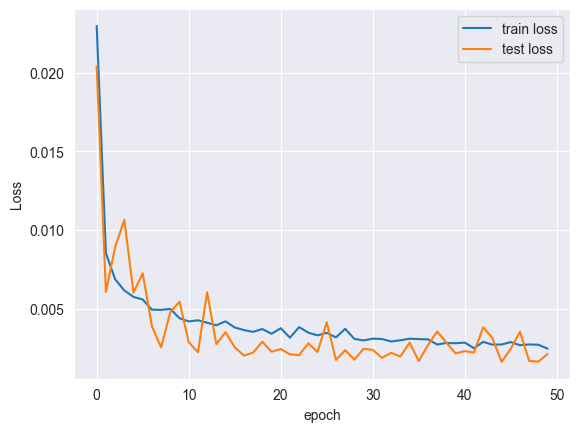

In [20]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

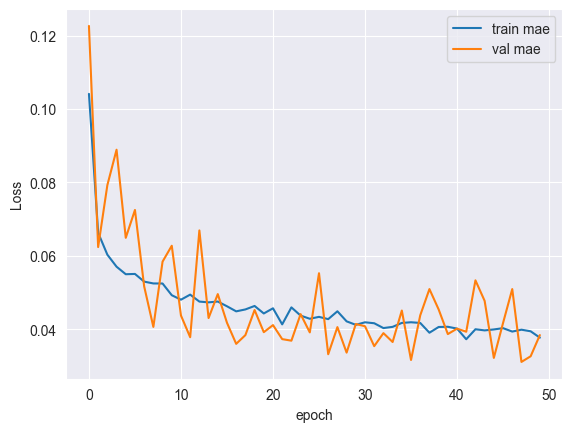

In [21]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

### Model 1 - LSTM - Plot

In [24]:
y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

8/8 [==============================] - 0s 9ms/step


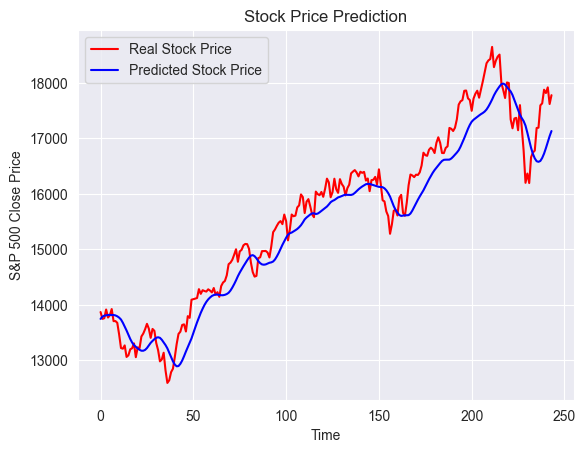

In [25]:
plt.plot(y_test_inversed, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred_inversed, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

### Model 1 - LSTM - Error Metrics

In [26]:
def calculate_error_metrics(y_test, y_pred):

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R²): {r2}')

    return

calculate_error_metrics(y_test_inversed, y_pred_inversed)

Mean Squared Error (MSE): 179510.1394130402
Mean Absolute Error (MAE): 353.57427077996925
R-squared (R²): 0.9241345670988803


## Model 2 - Bi-LSTM Model

In [27]:
# https://par.nsf.gov/servlets/purl/10186554

In [29]:
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='SGD', metrics=['mse', 'mae'])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=4)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 30, 100)          23200     
 nal)                                                            
                                                                 
 dropout_72 (Dropout)        (None, 30, 100)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dropout_73 (Dropout)        (None, 100)               0         
                                                                 
 dense_36 (Dense)            (None, 1)                 101       
                                                                 
Total params: 83,701
Trainable params: 83,701
Non-tra

In [30]:
val_loss = history.history['val_loss']
min_val_loss_epoch = val_loss.index(min(val_loss)) + 1 
min_val_loss_epoch

44

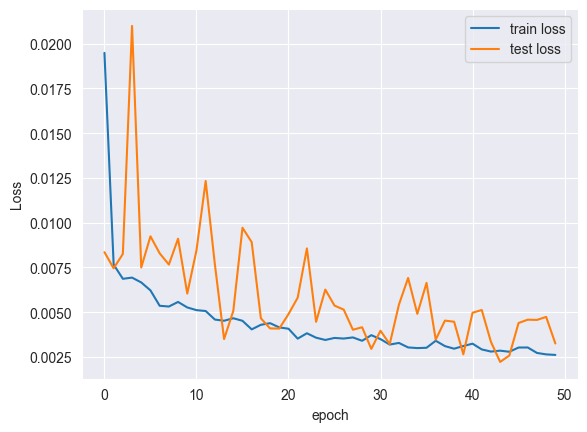

In [31]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

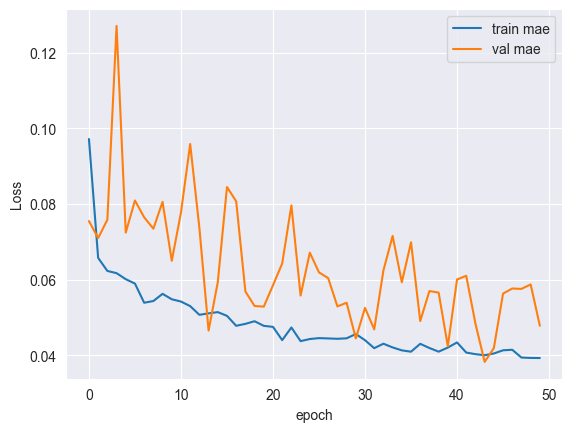

In [32]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

### Model 2 - Bi-LSTM - Plot

In [33]:
y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

8/8 [==============================] - 1s 10ms/step


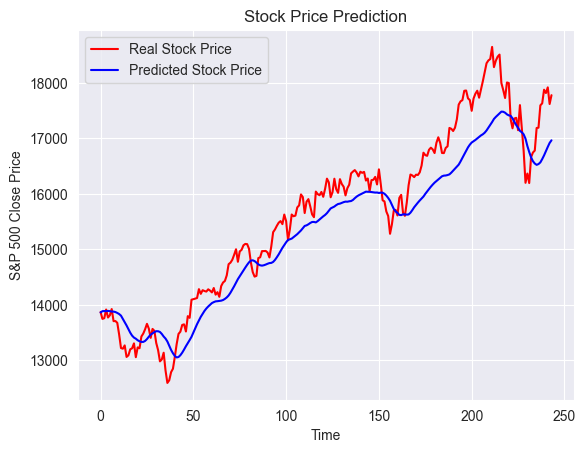

In [34]:
plt.plot(y_test_inversed, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred_inversed, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

### Model 2 - Bi-LSTM - Error Metrics

In [35]:
def calculate_error_metrics(y_test, y_pred):

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R²): {r2}')

    return

calculate_error_metrics(y_test_inversed, y_pred_inversed)

Mean Squared Error (MSE): 275323.0001159379
Mean Absolute Error (MAE): 439.53186235271517
R-squared (R²): 0.8836416780705072


## Model 3 - CNN-LSTM Model

In [36]:
# https://onlinelibrary.wiley.com/doi/epdf/10.1155/2021/9903518
# https://www.kaggle.com/code/dkdevmallya/deep-learning-cnn-lstm-time-series-forecasting

In [37]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(2))
# Don't need flatten!!

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='SGD', metrics=['mse', 'mae'])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=4)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 32)            704       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                                 
 lstm_74 (LSTM)              (None, 6, 50)             23000     
                                                                 
 dropout_74 (Dropout)        (None, 6, 50)           

In [38]:
val_loss = history.history['val_loss']
min_val_loss_epoch = val_loss.index(min(val_loss)) + 1 
min_val_loss_epoch

47

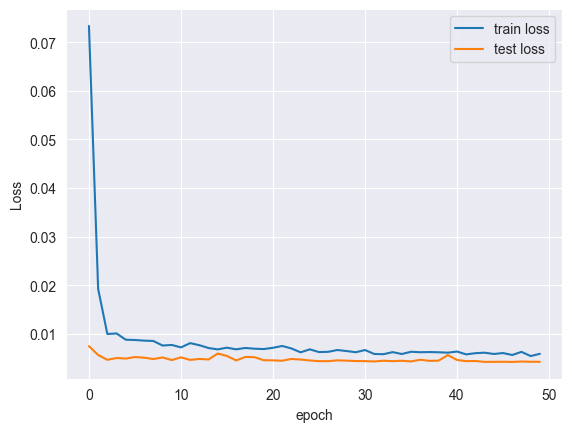

In [39]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

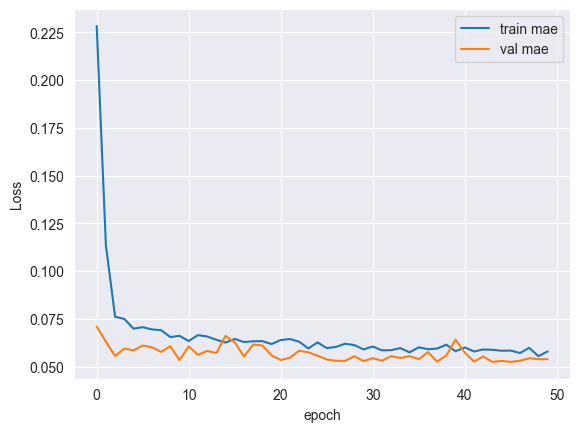

In [40]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

### Model 3 - CNN-LSTM - Plot

In [41]:
y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

8/8 [==============================] - 0s 2ms/step


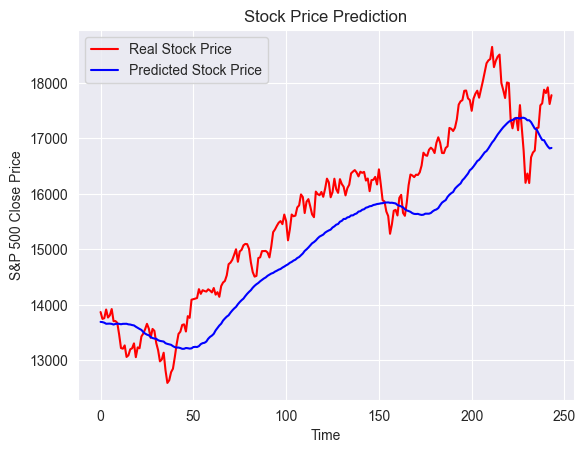

In [42]:
plt.plot(y_test_inversed, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred_inversed, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

### Model 3 - CNN-LSTM - Error Metrics

In [43]:
def calculate_error_metrics(y_test, y_pred):

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R²): {r2}')

    return

calculate_error_metrics(y_test_inversed, y_pred_inversed)

Mean Squared Error (MSE): 599495.685030089
Mean Absolute Error (MAE): 669.1730796939037
R-squared (R²): 0.7466382689252307


# Other Indexes/Stocks

In [44]:
'''
df_hsi = get_stock_data('^HSI', start_date, end_date)
df_cac40 = get_stock_data('^FCHI', start_date, end_date)
df_nasdaq = get_stock_data('^IXIC', start_date, end_date)
df_sp500 = get_stock_data('^GSPC', start_date, end_date)
df_dji = get_stock_data('^DJI', start_date, end_date)

df_aapl = get_stock_data('AAPL', start_date, end_date)
df_amzn = get_stock_data('AMZN', start_date, end_date)
df_googl = get_stock_data('GOOGL', start_date, end_date)
df_msft = get_stock_data('MSFT', start_date, end_date)
'''

# display(df_hsi.head(3))
# display(df_cac40.head(3))
# display(df_nasdaq.head(3))
# display(df_sp500.head(3))
# display(df_dji.head(3))

# display(df_aapl.head(3))
# display(df_amzn.head(3))
# display(df_googl.head(3))
# display(df_msft.head(3))

"\ndf_hsi = get_stock_data('^HSI', start_date, end_date)\ndf_cac40 = get_stock_data('^FCHI', start_date, end_date)\ndf_nasdaq = get_stock_data('^IXIC', start_date, end_date)\ndf_sp500 = get_stock_data('^GSPC', start_date, end_date)\ndf_dji = get_stock_data('^DJI', start_date, end_date)\n\ndf_aapl = get_stock_data('AAPL', start_date, end_date)\ndf_amzn = get_stock_data('AMZN', start_date, end_date)\ndf_googl = get_stock_data('GOOGL', start_date, end_date)\ndf_msft = get_stock_data('MSFT', start_date, end_date)\n"

# References

In [45]:
# https://github.com/yllvar/Stock-Prediction-LTSM